In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import trecs
from trecs.models import ContentFiltering
from trecs.metrics import *

## Analyzing Communities in MovieLens

In [145]:
ratings_df = pd.read_csv('data/ml-100k/u.data', 
                 sep="\t", 
                 names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [146]:
# Add 1000 to every MovieID so they don't overlap with UserID
ratings_df['MovieID'] = ratings_df['MovieID'] + 1000

In [147]:
ratings_df.sort_values('UserID').head(5)

,UserID,MovieID,Rating,Timestamp
66567,1,1055,5,875072688
62820,1,1203,4,878542231
10207,1,1183,5,875072262
9971,1,1150,5,876892196
22496,1,1068,4,875072688


MultiGraph with 2625 nodes and 100000 edges


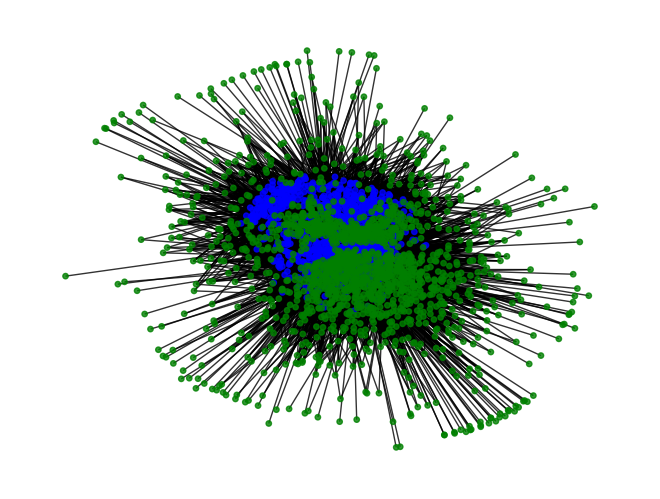

In [148]:
graph_dct = ratings_df.groupby('UserID')['MovieID'].apply(list).to_dict()

G = nx.MultiGraph(graph_dct)
print(nx.info(G))

# visualize graph
color_map = []
for node in G:
    if node < 1000:
        color_map.append('blue')
    else: 
        color_map.append('green')      


pos = nx.spring_layout(G)
nx.draw(G, node_color=color_map, node_size=15, alpha=0.8)
plt.show()

In [149]:
from community import community_louvain

comms = community_louvain.best_partition(G, resolution=2.5)

unique_coms = np.unique(list(comms.values()))
unique_coms

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76])

In [150]:
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow'
}

node_cmap = [cmap[v] for _,v in comms.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 10, alpha = 0.8, node_color=node_cmap)
plt.show()

KeyError: 64

In [ ]:
# Add comms to ratings_df as column communtyID
for i in range(len(ratings_df)):
    ratings_df.loc[i, 'communityID'] = comms[ratings_df.loc[i, 'UserID']]

In [ ]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp,communityID
0,196,1242,3,881250949,32.0
1,186,1302,3,891717742,22.0
2,22,1377,1,878887116,21.0
3,244,1051,2,880606923,33.0
4,166,1346,1,886397596,1.0


Text(0, 0.5, 'Number of Movies')

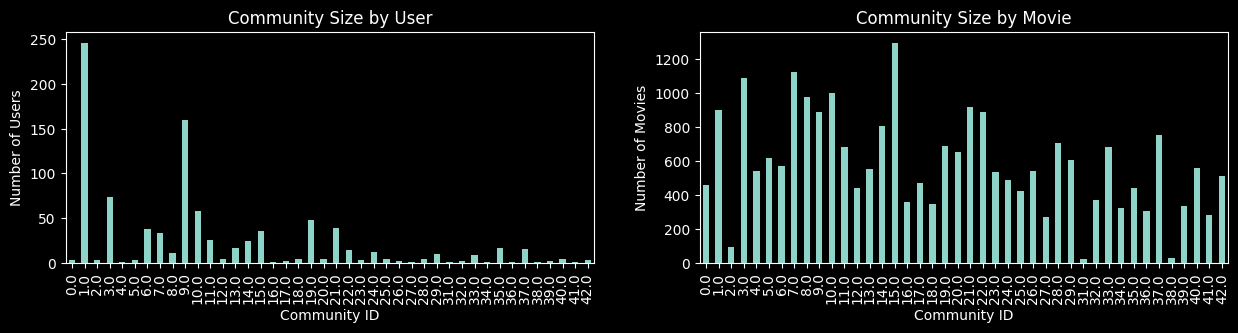

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ratings_df.groupby('communityID')['UserID'].nunique().plot(kind='bar', ax=ax[0])
ratings_df.groupby('communityID')['MovieID'].nunique().plot(kind='bar', ax=ax[1])

ax[0].set_title('Community Size by User')
ax[0].set_xlabel('Community ID')
ax[0].set_ylabel('Number of Users')
ax[1].set_title('Community Size by Movie')
ax[1].set_xlabel('Community ID')
ax[1].set_ylabel('Number of Movies')

Text(0.5, 1.0, 'Number of reached Communities')

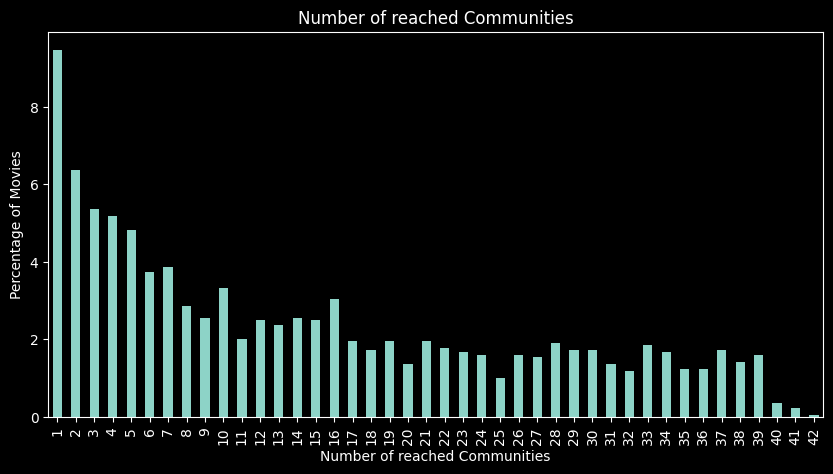

In [ ]:
num_movies = len(np.unique(ratings_df['MovieID']))
temp = ratings_df.groupby('MovieID')['communityID'].nunique().sort_values(ascending=True)
#group temp by value
temp = temp.groupby(temp.values).count()
#divide values of temp by num_movies
temp = temp/num_movies * 100
#create bar chart of temp in descending order
temp.plot(kind='bar', figsize=(10, 5))
# add axes
plt.xlabel('Number of reached Communities')
plt.ylabel('Percentage of Movies')
plt.title('Number of reached Communities')

In [168]:
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv('data/ml-100k/u.item', sep="|", names=movie_cols, encoding='latin')

display(movies_df.head(2))
print(movies_df.shape)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


(1682, 24)


In [ ]:
# join ratings_df and movies_df on movie_id
large_df = ratings_df.merge(movies_df, left_on='MovieID', right_on='movie_id')
large_df = large_df.drop(columns=['movie_id', 'release_date', 'video_release_date', 'Timestamp', 'Rating', 'title', 'IMDb_URL', 'unknown'])

large_df.head(2)
# group by communityID and sum all genre columns
genre_df = large_df.groupby('communityID').sum()
genre_df.head(5)
# for each communityID list the most common genre
# genre_df.drop(columns=['MovieID', 'UserID', 'Drama']).idxmax(axis=1)

,UserID,MovieID,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
communityID,,,,,,,,,,,,,,,,,,,,
0.0,203974,773060,69,29,13,32,208,50,18,291,7,7,16,17,11,77,19,70,15,6
1.0,3826470,9682498,469,127,20,177,2543,302,376,3769,108,168,86,260,188,1425,67,479,71,17
2.0,43685,107261,10,5,1,3,27,3,2,42,1,2,2,5,1,20,7,8,3,0
3.0,4100699,12544798,950,407,83,391,3223,834,302,4434,93,128,200,249,103,1516,205,903,415,49
4.0,170100,499008,39,15,6,21,126,30,14,175,4,6,6,9,5,45,9,40,11,3


## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [166]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)#

c:\Users\Jannik\Anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
c:\Users\Jannik\Anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


(943, 100)

In [167]:
nmf = NMF(n_components=100, solver="mu")
W = nmf.fit_transform(binary_ratings_matrix)
H = nmf.components_
print(W.shape, H.shape)

c:\Users\Jannik\Anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


(943, 100) (100, 1682)


c:\Users\Jannik\Anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [169]:
recsys = trecs.models.ContentFiltering(
    # num_users=number_of_users,
    # num_items=num_items,
    # num_attributes=number_of_attributes,
    user_representation=W,
    item_representation=H,
    record_base_state=True,
)

In [170]:
print(f"Number of users in system: {recsys.num_users}")
print(f"Number of items in system: {recsys.num_items}")

Number of users in system: 943
Number of items in system: 1682


In [171]:
print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {recsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {recsys.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


In [172]:
user_pairs = [(u_idx, v_idx) for u_idx in range(recsys.num_users) for v_idx in range(recsys.num_users)]

In [173]:
mse = MSEMeasurement(diagnostics=True)

recsys.add_metrics(InteractionMeasurement(),
                   mse,
                   InteractionSpread(),
                   RecSimilarity(pairs=user_pairs),
                   )

In [174]:
recsys.startup_and_train(timesteps=100)

100%|██████████| 100/100 [15:00<00:00,  9.01s/it]


In [175]:
measurements = recsys.get_measurements()
measurements.keys()

dict_keys(['interaction_histogram', 'mse', 'interaction_spread', 'rec_similarity', 'timesteps'])

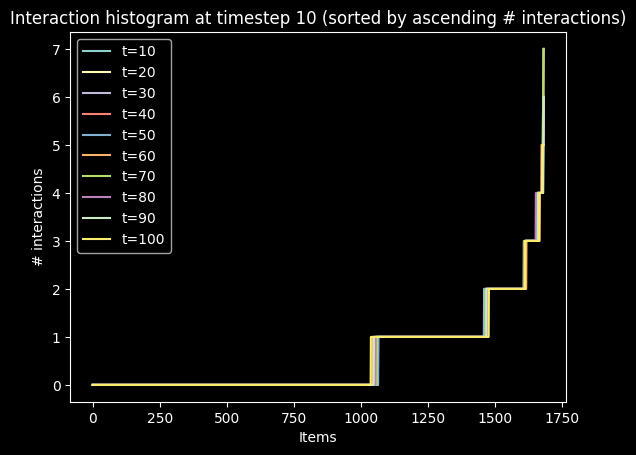

In [184]:
# for every 10 timesteps plot line in different color
for i in range(10, 101, 10):
    plt.plot(np.arange(recsys.num_items), sorted(measurements['interaction_histogram'][i]), label=f't={i}')

plt.legend()
plt.title("Interaction histogram at timestep %d (sorted by ascending # interactions)" % timestep)
plt.xlabel("Items")
plt.ylabel("# interactions")
plt.show()

In [186]:
pd.DataFrame(measurements)
#plot time series of mse over timesteps
# plt.plot(measurements['mse'])

,interaction_histogram,mse,interaction_spread,rec_similarity,timesteps
0,None,0.077926,NaN,NaN,0
1,"[2.0, 4.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",0.077926,-940.0,0.004164,1
2,"[1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 3.0, ...",0.077926,0.5,0.004155,2
3,"[5.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.077926,-0.5,0.004157,3
4,"[1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0.077926,-0.5,0.004206,4
...,...,...,...,...,...
96,"[0.0, 4.0, 0.0, 1.0, 2.0, 0.0, 4.0, 1.0, 2.0, ...",0.077926,0.0,0.004172,96
97,"[2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, ...",0.077926,0.0,0.004226,97
98,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, ...",0.077926,0.0,0.004173,98
99,"[1.0, 1.0, 2.0, 3.0, 3.0, 1.0, 0.0, 1.0, 2.0, ...",0.077926,1.5,0.004217,99


In [61]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In [ ]:
majority_minority_outcomes(mse, )